In [ ]:
import requests
from requests.auth import HTTPBasicAuth
from shapely.geometry import Point, shape
from datetime import datetime, timedelta
import geopandas as gpd
import pandas as pd
import os
import time
import fiona

# Innstillinger
client_id = "b24b755b-d187-448b-8676-9fdbb8e6fd80"
client_secret = "ed712d7e-32a2-4afd-8896-b987326ce4f6"
start_date = datetime(2015, 7, 21).date()
end_date = datetime.now().date()
output_dir = "lyn_per_dag"
os.makedirs(output_dir, exist_ok=True)
force_overskriv = True

# Last inn kommunegrenser fra Kartverket (Basisdata_kommune.geojson)
with fiona.open("Basisdata_kommune.geojson") as src:
    features = list(src)

kommune_records = []
for feature in features:
    props = feature["properties"]
    geom = shape(feature["geometry"])
    kommune_records.append({
        "kommune": props["kommunenavn"],
        "geometry": geom
    })

komm = gpd.GeoDataFrame(kommune_records, geometry="geometry", crs="EPSG:5973").to_crs("EPSG:4326")

# Funksjon for nedlasting og lagring (uten spatial join)
def hent_lyn_for_dato(dato):
    neste = dato + timedelta(days=1)
    outfile = os.path.join(output_dir, f"{dato}.csv")
    if os.path.exists(outfile) and not force_overskriv:
        print(f"{dato} allerede lastet ned.")
        return

    params = {
        "referencetime": f"{dato.isoformat()}T00:00:00Z/{neste.isoformat()}T00:00:00Z",
        "geometry": "POLYGON((4.5 57.9, 4.5 71.5, 31.5 71.5, 31.5 57.9, 4.5 57.9))"
    }

    url = "https://frost.met.no/lightning/v0.ualf"
    response = requests.get(url, params=params, auth=HTTPBasicAuth(client_id, client_secret))

    if response.status_code != 200 or not response.text.strip():
        print(f"{dato}: Ingen data ({response.status_code})")
        return

    rows = []
    for line in response.text.strip().splitlines():
        parts = line.split()
        if len(parts) < 10:
            continue
        ts = f"{parts[1]}-{parts[2]}-{parts[3]} {parts[4]}:{parts[5]}:{parts[6]}"
        lat = float(parts[8])
        lon = float(parts[9])
        rows.append({"dato": dato, "timestamp": ts, "lat": lat, "lon": lon})

    df = pd.DataFrame(rows)
    df.to_csv(outfile, index=False)
    print(f"{dato}: Lagret {len(df)} treff.")

# Fase 1: Last ned alle dager (uten spatial join)
dato = start_date
while dato <= end_date:
    try:
        hent_lyn_for_dato(dato)
        time.sleep(1.2)
    except Exception as e:
        print(f"Feil på {dato}: {e}")
    dato += timedelta(days=1)

2015-07-21: Lagret 1005 treff.
2015-07-22: Lagret 261 treff.
2015-07-23: Lagret 1049 treff.
2015-07-24: Lagret 1765 treff.
2015-07-25: Lagret 1477 treff.
2015-07-26: Lagret 2024 treff.
2015-07-27: Lagret 15 treff.
2015-07-28: Lagret 1 treff.
2015-07-29: Lagret 633 treff.
2015-07-30: Lagret 5401 treff.
2015-07-31: Lagret 3030 treff.
2015-08-01: Lagret 1573 treff.
2015-08-02: Lagret 6858 treff.
2015-08-03: Lagret 16 treff.
2015-08-04: Lagret 88 treff.
2015-08-05: Lagret 801 treff.
2015-08-06: Lagret 1895 treff.
2015-08-07: Lagret 3657 treff.
2015-08-08: Lagret 23180 treff.
2015-08-09: Lagret 17 treff.
2015-08-10: Lagret 52 treff.
2015-08-11: Lagret 4584 treff.
2015-08-12: Lagret 349 treff.
2015-08-13: Lagret 88 treff.
2015-08-14: Lagret 82 treff.
2015-08-15: Lagret 841 treff.
2015-08-16: Ingen data (200)
2015-08-17: Ingen data (200)
2015-08-18: Ingen data (200)
2015-08-19: Ingen data (200)
2015-08-20: Ingen data (200)
2015-08-21: Ingen data (200)
2015-08-22: Ingen data (200)
2015-08-23: 

C:\Users\jakob\AppData\Local\Temp\ipykernel_28532\1911367600.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((pd.read_csv(os.path.join(output_dir, f)) for f in alle_filer), ignore_index=True)


Konverterer til GeoDataFrame...
Utfører spatial join...
Beregner statistikk...


KeyError: 'kommune'

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import shape

# Last inn kommunegrenser med geometri, navn og kommunenummer
with fiona.open("Basisdata_kommune.geojson") as src:
    features = list(src)

kommune_records = []
for feature in features:
    props = feature["properties"]
    geom = shape(feature["geometry"])
    kommune_records.append({
        "kommunenummer": props["kommunenummer"],
        "kommune": props["kommunenavn"],
        "geometry": geom
    })

komm = gpd.GeoDataFrame(kommune_records, geometry="geometry", crs="EPSG:5973").to_crs("EPSG:4326")

# Innstillinger
output_dir = "lyn_per_dag"
geojson_fil = "Basisdata_kommune.geojson"
ssb_fil = "09280_20250723-103908.xlsx"
start_date = pd.to_datetime("2015-07-21")
end_date = pd.to_datetime("2025-07-22")
år = (end_date - start_date).days / 365.25

# Les og kombiner lynfiler
print("Leser alle CSV-filer...")
alle_filer = [f for f in os.listdir(output_dir) if f.endswith(".csv")]
df = pd.concat((pd.read_csv(os.path.join(output_dir, f)) for f in alle_filer), ignore_index=True)

# Gjør til GeoDataFrame og spatial join
print("Konverterer til GeoDataFrame og utfører spatial join...")
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326")
gdf = gpd.sjoin(gdf, komm[["geometry", "kommunenummer", "kommune"]], how="left", predicate="within")
# Etter spatial join: rydd kolonner
gdf["kommune"] = gdf["kommune_right"]
gdf.drop(columns=["kommune_left", "kommune_right"], inplace=True)


# Tell lyn per kommune
print("Beregner lyn per kommune...")
lyn_per_kommune = gdf.groupby(["kommune", "kommunenummer"]).size().reset_index(name="lyn_treff")
lyn_per_kommune["lyn_per_år"] = lyn_per_kommune["lyn_treff"] / år
lyn_per_kommune["andel (%)"] = lyn_per_kommune["lyn_treff"] / lyn_per_kommune["lyn_treff"].sum() * 100

# Varsle om manglende kommunenummer
uten_knr = lyn_per_kommune[lyn_per_kommune["kommunenummer"].isna()]
if not uten_knr.empty:
    print("\n Følgende kommuner mangler kommunenummer og kan ikke matches med SSB:")
    print(uten_knr["kommune"].to_list())

# Les offisiell arealtabell fra SSB
print("Leser arealdata fra SSB...")
areal_ssb = pd.read_excel(ssb_fil, skiprows=4, engine="openpyxl")
areal_ssb = areal_ssb.rename(columns={"Unnamed: 0": "kommuneinfo"})
areal_ssb[["kommunenummer", "ssb_kommune"]] = areal_ssb["kommuneinfo"].str.extract(r"K-(\d+)\s+(.+)")
areal_ssb["areal_km2"] = areal_ssb["Landareal"].astype(float) + areal_ssb["Ferskvatn"].astype(float)
ssb_areal = areal_ssb[["kommunenummer", "areal_km2"]].dropna()
ssb_areal["kommunenummer"] = ssb_areal["kommunenummer"].astype(str)

# Match og erstatt areal
print("Slår sammen lynstatistikk med SSB-areal...")
lyn_per_kommune["kommunenummer"] = lyn_per_kommune["kommunenummer"].astype(str)
resultat = pd.merge(lyn_per_kommune, ssb_areal, on="kommunenummer", how="left")

# Beregn tetthet
resultat["lyn_per_km2_per_år"] = resultat["lyn_per_år"] / resultat["areal_km2"]

# Print kommuner uten arealmatch
uten_areal = resultat[resultat["areal_km2"].isna()]
if not uten_areal.empty:
    print("\n Følgende kommuner fikk ikke match på areal fra SSB:")
    print(uten_areal[["kommunenummer", "kommune"]])

# Lagre resultat
resultat.to_csv("lynstatistikk_kommune_2015_2025.csv", index=False)
print(f"\n Lagret statistikk for {len(resultat)} kommuner.")


Leser alle CSV-filer...


C:\Users\jakob\AppData\Local\Temp\ipykernel_20256\2348148412.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((pd.read_csv(os.path.join(output_dir, f)) for f in alle_filer), ignore_index=True)


Konverterer til GeoDataFrame og utfører spatial join...
Beregner lyn per kommune...
Leser arealdata fra SSB...
Slår sammen lynstatistikk med SSB-areal...

✅ Ferdig! Lagret statistikk for 357 kommuner.


In [ ]:
import os
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import shape

# Last inn kommunegrenser med geometri, navn og kommunenummer
with fiona.open("Basisdata_kommune.geojson") as src:
    features = list(src)

kommune_records = []
for feature in features:
    props = feature["properties"]
    geom = shape(feature["geometry"])
    kommune_records.append({
        "kommunenummer": props["kommunenummer"],
        "kommune": props["kommunenavn"],
        "geometry": geom
    })

komm = gpd.GeoDataFrame(kommune_records, geometry="geometry", crs="EPSG:5973").to_crs("EPSG:4326")

#  Innstillinger
output_dir = "lyn_per_dag"
ssb_fil = "09280_20250723-103908.xlsx"
start_date = pd.to_datetime("2015-07-21")
end_date = pd.to_datetime("2025-07-22")
år = (end_date - start_date).days / 365.25

# Les og kombiner lynfiler
print("Leser alle CSV-filer...")
alle_filer = [f for f in os.listdir(output_dir) if f.endswith(".csv")]
df = pd.concat((pd.read_csv(os.path.join(output_dir, f)) for f in alle_filer), ignore_index=True)

# Spatial join
print("Utfører spatial join...")
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326")
gdf = gpd.sjoin(gdf, komm[["geometry", "kommunenummer", "kommune"]], how="left", predicate="within")
gdf["kommune"] = gdf["kommune_right"]
gdf.drop(columns=["kommune_left", "kommune_right"], inplace=True)

# Tell lyn per kommune
print("Teller lyn per kommune...")
lyn_per_kommune = gdf.groupby(["kommune", "kommunenummer"]).size().reset_index(name="lyn_treff")
lyn_per_kommune["lyn_per_år"] = lyn_per_kommune["lyn_treff"] / år
lyn_per_kommune["andel (%)"] = lyn_per_kommune["lyn_treff"] / lyn_per_kommune["lyn_treff"].sum() * 100
lyn_per_kommune["kommunenummer"] = lyn_per_kommune["kommunenummer"].astype(str)

# Beregn administrativt areal fra GeoJSON
print("Beregner areal fra kommunegeometri...")
komm_m2 = komm.to_crs("EPSG:25833")
komm_m2["areal_admin_km2"] = komm_m2.geometry.area / 1e6
areal_admin = komm_m2[["kommunenummer", "areal_admin_km2"]].groupby("kommunenummer").sum().reset_index()

# Les SSB-areal
print("Leser arealdata fra SSB...")
areal_ssb = pd.read_excel(ssb_fil, skiprows=4, engine="openpyxl")
areal_ssb = areal_ssb.rename(columns={"Unnamed: 0": "kommuneinfo"})
areal_ssb[["kommunenummer", "ssb_kommune"]] = areal_ssb["kommuneinfo"].str.extract(r"K-(\d+)\s+(.+)")
areal_ssb["areal_km2"] = areal_ssb["Landareal"].astype(float) + areal_ssb["Ferskvatn"].astype(float)
ssb_areal = areal_ssb[["kommunenummer", "areal_km2"]].dropna()
ssb_areal["kommunenummer"] = ssb_areal["kommunenummer"].astype(str)

# Kombiner data
print("Slår sammen og beregner justert statistikk...")
df_merge = lyn_per_kommune.merge(ssb_areal, on="kommunenummer", how="left")
df_merge = df_merge.merge(areal_admin, on="kommunenummer", how="left")

# Beregn skalafaktor
df_merge["skalafaktor"] = df_merge["areal_km2"] / df_merge["areal_admin_km2"]

# Beregn justert statistikk
df_merge["lyn_treff_justert"] = df_merge["lyn_treff"] * df_merge["skalafaktor"]
df_merge["lyn_per_år_justert"] = df_merge["lyn_per_år"] * df_merge["skalafaktor"]
df_merge["lyn_per_km2_per_år_justert"] = df_merge["lyn_per_år_justert"] / df_merge["areal_km2"]

# Velg relevante kolonner for eksport
kolonner = [
    "kommunenummer", "kommune",
    "lyn_treff_justert",
    "lyn_per_år_justert",
    "lyn_per_km2_per_år_justert",
    "andel (%)"
]

final = df_merge[kolonner].copy()

# Lag CSV med kolonnebeskrivelser
csv_fil = "lynstatistikk_justert_2015_2025.csv"
print(f"Lagrer justert statistikk til {csv_fil}...")

beskrivelser = {
    "kommunenummer": "Offisielt kommunenummer",
    "kommune": "Kommunenavn",
    "lyn_treff_justert": "Estimert antall lyn innenfor landareal (2015-2025)",
    "lyn_per_år_justert": "Årlig gjennomsnitt lyn innenfor landareal",
    "lyn_per_km2_per_år_justert": "Lyntetthet per km² landareal per år",
    "andel (%)": "Andel av totale lyn i Norge (%)"
}

with open(csv_fil, "w", encoding="utf-8") as f:
    for kol, forklaring in beskrivelser.items():
        f.write(f"# {kol}: {forklaring}\n")
    final.to_csv(f, index=False)

print(f"\n Ferdig! Lagret justert statistikk for {len(final)} kommuner.")


Leser alle CSV-filer...


C:\Users\jakob\AppData\Local\Temp\ipykernel_19272\302359823.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((pd.read_csv(os.path.join(output_dir, f)) for f in alle_filer), ignore_index=True)


Utfører spatial join...
Teller lyn per kommune...
Beregner areal fra kommunegeometri...
Leser arealdata fra SSB...
Slår sammen og beregner justert statistikk...
Lagrer justert statistikk til lynstatistikk_justert_2015_2025.csv...

✅ Ferdig! Lagret justert statistikk for 357 kommuner.


In [3]:
!pip install fiona


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


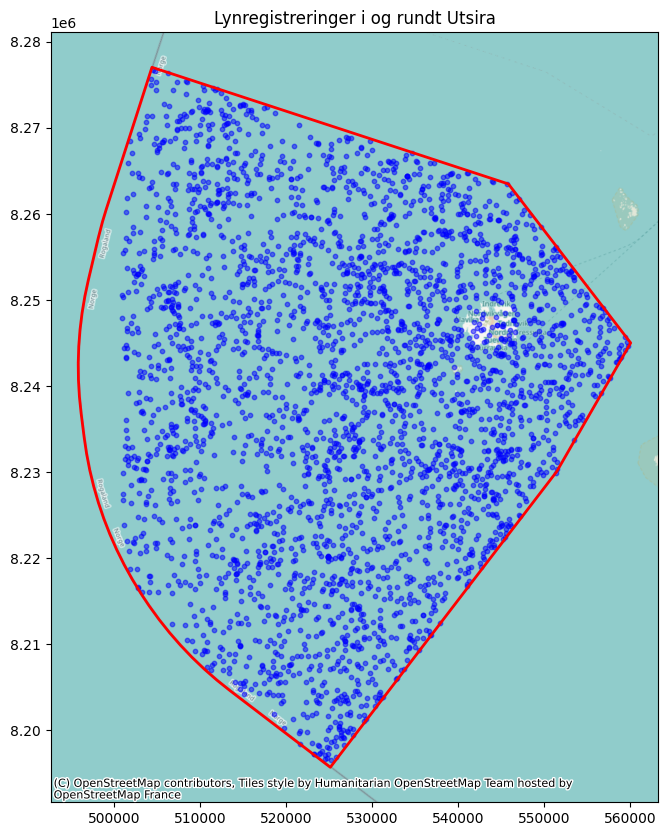

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

# Last lynpunkter fra df
lyn = df.copy()
lyn = lyn[(lyn["lat"].notna()) & (lyn["lon"].notna())]

# Filtrer på bare treff i Utsira (fra spatial join)
utsira_knr = komm[komm["kommunenavn"] == "Utsira"]["kommunenummer"].values[0]
utsira_treff = gdf[gdf["kommunenummer"] == utsira_knr]

# Plukk ut de samme treffene fra df (basert på timestamp + lat/lon)
lyn = df.merge(utsira_treff[["timestamp", "lat", "lon"]], on=["timestamp", "lat", "lon"], how="inner")

# Lag GeoDataFrame
lyn_gdf = gpd.GeoDataFrame(
    lyn,
    geometry=gpd.points_from_xy(lyn["lon"], lyn["lat"]),
    crs="EPSG:4326"
).to_crs("EPSG:3857")

# Hent Utsira-grensa
utsira_poly = komm[komm["kommunenummer"] == utsira_knr].to_crs("EPSG:3857")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
utsira_poly.boundary.plot(ax=ax, color="red", linewidth=2)
lyn_gdf.plot(ax=ax, color="blue", alpha=0.5, markersize=10)
cx.add_basemap(ax)
ax.set_title("Lynregistreringer i og rundt Utsira")
plt.show()


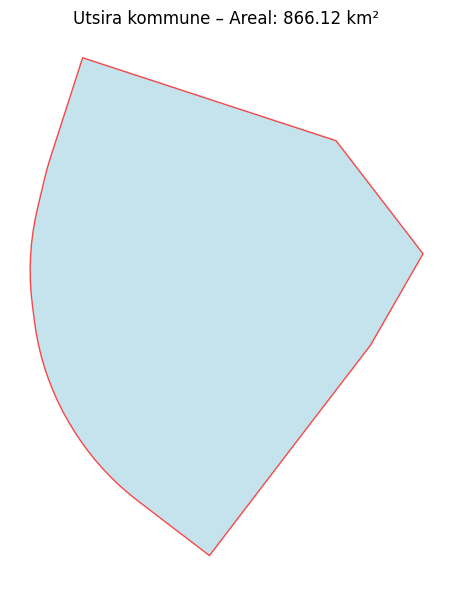

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Last inn kommunegrenser
komm = gpd.read_file("Basisdata_kommune.geojson")

# Transformér til et projeksjon med meter som enhet
komm_m = komm.to_crs(epsg=25833)

# Filtrer til bare Utsira
utsira = komm_m[komm_m["kommunenavn"].str.lower() == "utsira"]

# Beregn areal i km
areal_km2 = utsira.geometry.area.iloc[0] / 1e6

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
utsira.to_crs(epsg=3857).plot(ax=ax, edgecolor="red", facecolor="lightblue", alpha=0.7)
ax.set_title(f"Utsira kommune – Areal: {areal_km2:.2f} km²")
ax.axis("off")
plt.tight_layout()
plt.show()